## Training a better Model

In [1]:
from theano.sandbox import cuda

In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [15]:
path = "../../data/dogscats/sample/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=4

## Underfitting - how to check
Underfitting : Validation Accuracy >> Training Accuracy
Overfitting : Training Accuracy >> Validation Accuracy

In our case, we have underfitting, due to dropout layer. we have 
dropout layer which randomly deletes each activation in the previous
layer - dropout does not happed in validation stage. Thus we 
have lower accuracy in Training as compared to Validation.

Purpose of dropout is - avoid overfitting. - no part can overfit
any part of the training. 

Underfitting is not desirable - validation acc is better than training 
accuracy. 

In [8]:
model = vgg_ft(2)
model.load_weights(model_path+'finetune3.h5')

we need to train without dropouts - which are in dense layers
not in convolution layers - better to precompute the inputs to 
fully connected layers i.e. Flatten layer.
Get the model upto this layer including this layer

In [10]:
layers = model.layers
# enumerate is used to the numeric index for the loop
last_conv_idx = [index for index,layer in enumerate(layers)
                        if type(layer) is Convolution2D][-1]
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [11]:
last_conv_idx

30

In [12]:
layers[last_conv_idx]

In [50]:
conv_layers = layers[:last_conv_idx+1]
# create a convolution layer only model - using Sequential Keras API
conv_model = Sequential(conv_layers)
# get the fully connected layers
fc_layers = layers[last_conv_idx+1:]

Now simply create features for the new FC or densely connected layers

In [20]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 160 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [21]:
batches.class_indices

{'cats': 0, 'dogs': 1}

In [22]:
val_features = conv_model.predict_generator(val_batches,val_batches.nb_sample)

In [28]:
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

In [31]:
save_array(model_path + 'train_convlayer_features.bc', trn_features)

In [33]:
save_array(model_path + 'valid_convlayer_features.bc', val_features)

In [34]:
trn_features = load_array(model_path+'train_convlayer_features.bc')
val_features = load_array(model_path+'valid_convlayer_features.bc')

In [37]:
# training features can be expressed as 4D tensor
# 160 images, 512 = channels, width = 15, height = 15
trn_features.shape

(160, 512, 14, 14)

In [44]:
# get the shape of the last conv layer
conv_layers[-1].output_shape[1:]

(512, 14, 14)

For new fully connected layer, we will use same architecture as 
VGG16 last layers - so that we can copy the pretrained weights from that model.

In [67]:
# copying the weights from pre-trained model - as we 
# are removing dropout (0.5) : we want to half the weights
def proc_wgts(layer): 
    print(layer.get_weights())
    return [o/2 for o in layer.get_weights()]

In [68]:
opt = RMSprop(lr=0.00001, rho=0.7)

In [82]:
def get_fc_model():
    # simply create a new model with '0' dropout
    # also use pretrained weight
    model = Sequential([
            MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.),
            Dense(4096, activation='relu'),
            Dropout(0.),
            Dense(2, activation='softmax')
        ])
    # zip will get the iterator to both the layers, can be used to copy weights
    for l1, l2 in zip(model.layers, fc_layers):l1.set_weights(proc_wgts(l2))
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [83]:
fc_model = get_fc_model()

[]
[]
[array([[  1.9746e-05,   3.5309e-04,  -1.8328e-03, ...,   3.9865e-05,  -2.8763e-03,   3.3548e-03],
       [  4.5399e-04,  -1.6271e-03,  -2.2679e-03, ...,  -2.1454e-03,  -3.0396e-03,   2.8342e-04],
       [  5.5663e-04,  -3.1813e-03,  -1.5065e-03, ...,  -2.2823e-03,  -3.7002e-03,  -7.0679e-04],
       ..., 
       [  1.8427e-03,   6.4293e-04,   2.4107e-03, ...,  -1.9897e-03,   2.6534e-03,  -3.3772e-03],
       [ -2.0984e-04,   1.1995e-03,   1.3821e-03, ...,  -2.6909e-03,   1.5766e-04,  -4.7684e-03],
       [  6.6753e-04,   1.8267e-03,   1.1026e-03, ...,  -1.7053e-03,   1.8931e-03,  -5.1029e-03]], dtype=float32), array([-0.1887,  0.1266, -0.2996, ..., -0.1838,  0.1745, -0.1672], dtype=float32)]
[]
[array([[  3.9015e-03,  -1.8081e-03,   1.3616e-03, ...,   1.0519e-03,  -5.8324e-03,   1.5550e-03],
       [  5.3532e-03,  -2.3154e-03,  -3.6157e-03, ...,  -8.4153e-04,  -1.5587e-03,   5.2203e-03],
       [ -3.1341e-03,  -8.6072e-05,   2.8132e-03, ...,   2.3308e-03,   4.5287e-03,  -6.2349e

In [86]:
fc_model.fit(trn_features, trn_labels, nb_epoch=8, 
            batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 160 samples, validate on 160 samples
Epoch 1/8
160/160 [==============================] - 39s - loss: 0.4779 - acc: 0.9625 - val_loss: 0.2269 - val_acc: 0.9812
Epoch 2/8
160/160 [==============================] - 46s - loss: 0.2269 - acc: 0.9813 - val_loss: 0.2007 - val_acc: 0.9875
Epoch 3/8
160/160 [==============================] - 58s - loss: 0.1959 - acc: 0.9875 - val_loss: 1.1995e-07 - val_acc: 1.0000
Epoch 4/8
160/160 [==============================] - 73s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/8
160/160 [==============================] - 164s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 6/8
160/160 [==============================] - 253s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 7/8
160/160 [==============================] - 452s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 8/8
160/160 [==============================] - 5

In [88]:
fc_model.save_weights(model_path+'no_dropouts.h5')
fc_model.save_weights(model_path+'no_dropouts.h5')

## Reducing Overfitting : 
When training accuracy >> validation accuracy - we are overfitting
1. add more data
2. data augmentation
3. architecture changes 
4. add regularization
5. dropout
6. reduce arch complexity

## Data Augmentation
Creating additional synthetic data with some modifications - 
flipping, rotation, zooming, cropping, panning, minor color changes

In [89]:
# with ImageDataGenerator - get tensor images with Data augmentation
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True, dim_ordering='tf')

In [103]:
img = np.expand_dims(ndimage.imread('../../data/dogscats/test/7.jpg'),0)
# request the generator to create batches from this image
aug_iter = gen.flow(img)

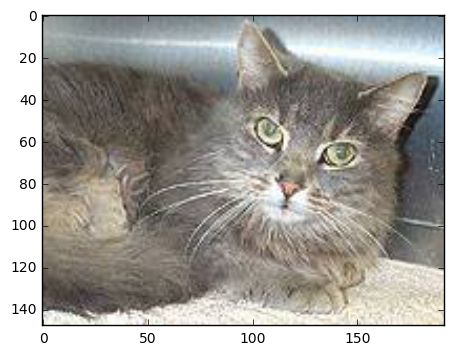

In [104]:
# the original
plt.imshow(img[0])

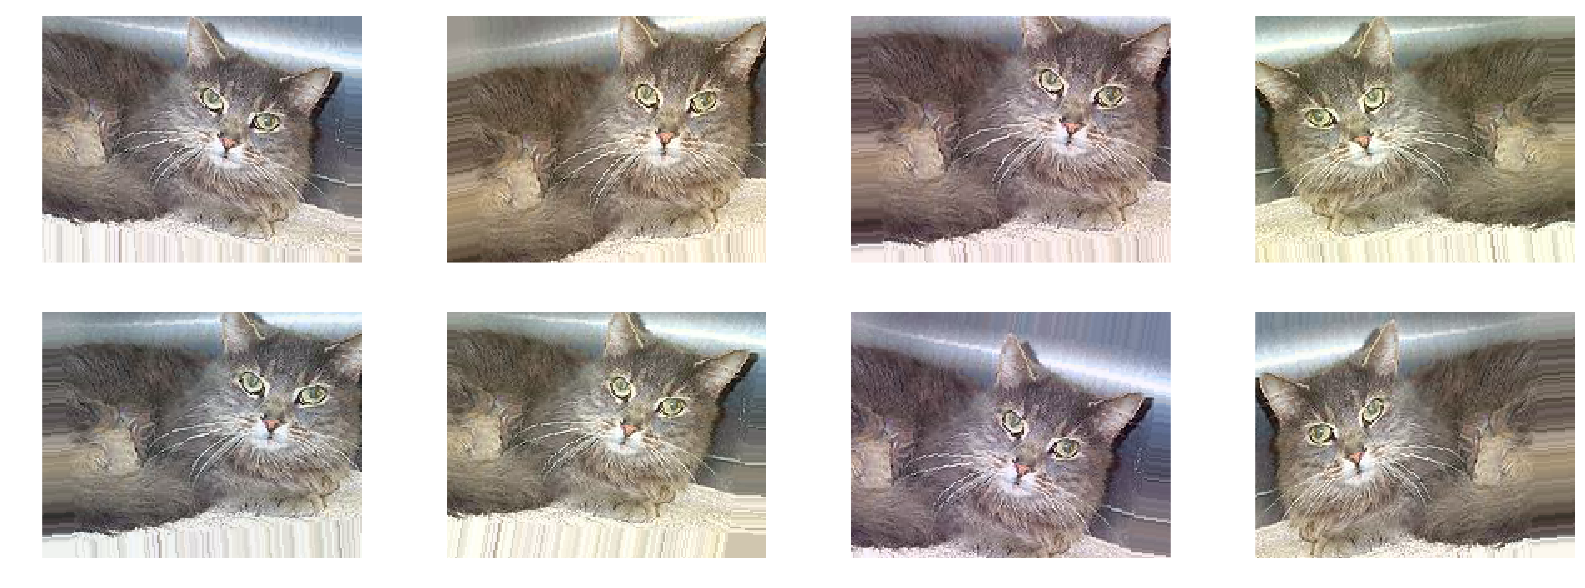

In [105]:
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]
plots(aug_imgs, (20,7), 2)

In [106]:
# Ensure that we return to theano dimension ordering
K.set_image_dim_ordering('th')

In [107]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [108]:
# only add data augmentation to training set
batches = get_batches(path+'train', gen, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


With data augmentation, we can not precompute our convolutional layer features, as every
image is augmented and different. 

In [109]:
fc_model = get_fc_model()
# the conv layers wont get retrained now
for layer in conv_model.layers: layer.trainable = False
    
# simply connect two models - conv model with fully connected model
conv_model.add(fc_model)

[]
[]
[array([[  1.9746e-05,   3.5309e-04,  -1.8328e-03, ...,   3.9865e-05,  -2.8763e-03,   3.3548e-03],
       [  4.5399e-04,  -1.6271e-03,  -2.2679e-03, ...,  -2.1454e-03,  -3.0396e-03,   2.8342e-04],
       [  5.5663e-04,  -3.1813e-03,  -1.5065e-03, ...,  -2.2823e-03,  -3.7002e-03,  -7.0679e-04],
       ..., 
       [  1.8427e-03,   6.4293e-04,   2.4107e-03, ...,  -1.9897e-03,   2.6534e-03,  -3.3772e-03],
       [ -2.0984e-04,   1.1995e-03,   1.3821e-03, ...,  -2.6909e-03,   1.5766e-04,  -4.7684e-03],
       [  6.6753e-04,   1.8267e-03,   1.1026e-03, ...,  -1.7053e-03,   1.8931e-03,  -5.1029e-03]], dtype=float32), array([-0.1887,  0.1266, -0.2996, ..., -0.1838,  0.1745, -0.1672], dtype=float32)]
[]
[array([[  3.9015e-03,  -1.8081e-03,   1.3616e-03, ...,   1.0519e-03,  -5.8324e-03,   1.5550e-03],
       [  5.3532e-03,  -2.3154e-03,  -3.6157e-03, ...,  -8.4153e-04,  -1.5587e-03,   5.2203e-03],
       [ -3.1341e-03,  -8.6072e-05,   2.8132e-03, ...,   2.3308e-03,   4.5287e-03,  -6.2349e

In [110]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

## Batch Normalization
Reduce the ability of small number of outlying weights to over influence
the training - also reduces overfitting

How it works:
1. multiply "GAMMA" to all the activations with standard deviations
2. add "BETA" to set mean to all the activations
if GAMMA = standard deviation, BETA = mean - we get original input
we can basically control how to normalize the inputs

With the normalizationa, GAMMA and BETA (learnt parameters) - use them 
during backpropagation for SGD calculation to minimize loss functions

In [111]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

In [112]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1000, activation='softmax')
        ]

In [116]:
from vgg16bn import Vgg16BN

In [121]:
def load_fc_weights_from_vgg16bn(model):
    "load weights for model from dense layers of VGG16BN model"
    from vgg16bn import Vgg16BN
    vgg16_bn = Vgg16BN()
    _, fc_layers = split_at(vgg16_bn.model, Convolution2D)
    copy_weights(fc_layers, model.layers)

In [122]:
p = 0.6

In [123]:
bn_model = Sequential(get_bn_layers(0.6))

In [124]:
load_fc_weights_from_vgg16bn(bn_model)

553492480/553620808 [============================>.] - ETA: 0s

In [125]:
def proc_wgts(layer, prev_p, new_p):
    scal = (1-prev_p)/(1-new_p)
    return [o*scal for o in layer.get_weights()]

In [126]:
for l in bn_model.layers: 
    if type(l)==Dense: l.set_weights(proc_wgts(l, 0.5, 0.6))

In [127]:
bn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_12 (MaxPooling2D)   (None, 512, 7, 7)     0           maxpooling2d_input_7[0][0]       
____________________________________________________________________________________________________
flatten_8 (Flatten)              (None, 25088)         0           maxpooling2d_12[0][0]            
____________________________________________________________________________________________________
dense_23 (Dense)                 (None, 4096)          102764544   flatten_8[0][0]                  
____________________________________________________________________________________________________
batchnormalization_3 (BatchNormal(None, 4096)          8192        dense_23[0][0]                   
___________________________________________________________________________________________

In [128]:
bn_model.pop()

In [129]:
bn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_12 (MaxPooling2D)   (None, 512, 7, 7)     0           maxpooling2d_input_7[0][0]       
____________________________________________________________________________________________________
flatten_8 (Flatten)              (None, 25088)         0           maxpooling2d_12[0][0]            
____________________________________________________________________________________________________
dense_23 (Dense)                 (None, 4096)          102764544   flatten_8[0][0]                  
____________________________________________________________________________________________________
batchnormalization_3 (BatchNormal(None, 4096)          8192        dense_23[0][0]                   
___________________________________________________________________________________________

In [130]:
# set all the dense layers as non trainable
for layer in bn_model.layers: layer.trainable=False

In [131]:
bn_model.add(Dense(2, activation='softmax'))

In [132]:
bn_model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [133]:
bn_model.fit(trn_features, trn_labels, nb_epoch=1, validation_data=(val_features, val_labels))

Train on 160 samples, validate on 160 samples
Epoch 1/1
160/160 [==============================] - 0s - loss: 1.6473 - acc: 0.6312 - val_loss: 0.3977 - val_acc: 0.8625


In [134]:
bn_model.save_weights(model_path+'bn.h5')

In [135]:
bn_model.load_weights(model_path+'bn.h5')

In [136]:
bn_layers = get_bn_layers(0.6)


In [138]:
bn_layers

In [139]:
bn_layers.pop()
bn_layers.append(Dense(2,activation='softmax'))

In [140]:
bn_layers

In [148]:
final_model = Sequential(conv_layers)
for layer in final_model.layers: layer.trainable = False
for layer in bn_layers : final_model.add(layer)

In [149]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
___________________________________________________________________________________________

In [150]:
# set the new bn_layer weights from the previous bn_model
for l1, l2 in zip(bn_model.layers, bn_layers):
    l2.set_weights(l1.get_weights())

In [151]:
bn_model.layers

In [152]:
bn_layers

In [153]:
# bn_model has different dropout - then bn_layers
final_model.compile(optimizer=Adam(), 
                    loss='categorical_crossentropy', metrics=['accuracy'])

In [154]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
160/160 [==============================] - 118s - loss: 2.6926 - acc: 0.7312 - val_loss: 0.9746 - val_acc: 0.9250


In [155]:
final_model.save_weights(model_path + 'final1.h5')